### Importing Libraries  

In this step, we import the essential Python libraries required for building our **Movie Recommender System**:  

- **os, warnings** → Handle file paths and suppress unnecessary warnings.  
- **numpy, pandas** → Data manipulation and analysis.  
- **scikit-learn**  
  - `TfidfVectorizer` → Converts movie genres/tags into numerical vectors for content-based filtering.  
  - `linear_kernel`, `cosine_similarity` → Measure similarity between movies.  
  - `MultiLabelBinarizer` → Preprocess multi-genre data into binary format.  
  - `train_test_split` → Split data for training and testing collaborative models.  
- **matplotlib, seaborn** → Visualization of data distributions and rating patterns.  

These libraries form the backbone of our project, handling data processing, feature extraction, similarity computation, and visualization.

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

### Installing Dependencies  

Since we are using the **Surprise library** (`scikit-surprise`) for collaborative filtering (SVD),  
we need to install it along with a compatible version of **NumPy**.  

> Note: On some systems (especially macOS and since I'm using macOS), `scikit-surprise` requires forcing a reinstall of NumPy for compatibility. 

The following command ensures the correct setup:  

- `numpy==1.24.3` → Stable version compatible with scikit-surprise.  
- `scikit-surprise` → Library for building and training collaborative filtering models (SVD, KNN, etc.).

In [2]:
!pip install --force-reinstall numpy==1.24.3 scikit-surprise

  Using cached numpy-1.24.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.6 kB)
  Using cached scikit_surprise-1.1.4-cp311-cp311-macosx_11_0_arm64.whl
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached scipy-1.16.1-cp311-cp311-macosx_14_0_arm64.whl.metadata (61 kB)
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
  Using cached scipy-1.16.0-cp311-cp311-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached scipy-1.15.3-cp311-cp311-macosx_14_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.24.3-cp311-cp311-macosx_11_0_arm64.whl (13.8 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached scipy-1.15.3-cp311-cp311-macosx_14_0_arm64.whl (22.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: joblib━━━━━━━━━━━━━━━━━━ 0/4 [numpy]
   

### Importing Surprise Library Components  

Now that we have installed **scikit-surprise**, we import the required classes and functions:  

- `Dataset` & `Reader` → To load and parse the ratings dataset into a format that Surprise understands.  
- `SVD` → Singular Value Decomposition algorithm (Collaborative Filtering).  
- `KNNBasic` → A simple k-Nearest Neighbors based collaborative filtering algorithm.  
- `train_test_split` → Function to split data into train and test sets (specific to Surprise).  
- `accuracy` → For evaluating model performance (e.g., RMSE, MAE).  
- `GridSearchCV` → For hyperparameter tuning of Surprise models.  

In [3]:
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV

### Handling Model Persistence  

We also import the `pickle` library, which allows us to save and load trained models for later use.  
This ensures we don’t need to retrain the recommendation model every time we run the code.    

In [4]:
import pickle

### Defining Dataset Directory  

We specify the path to our dataset folder.  
All the raw data files (like `movies.csv`, `ratings.csv`, etc.) have been stored inside this **`Dataset`** directory.

In [5]:
DATA_DIR = 'Dataset'

### Defining File Paths for Dataset Files  

We use `os.path.join` to create full paths to the key dataset files stored inside the `Dataset` directory:  

- `links.csv` → Contains mapping between movie IDs and external database IDs.  
- `movies.csv` → Contains movie titles and associated metadata.  
- `ratings.csv` → Contains user ratings for movies.  
- `tags.csv` → Contains user-generated tags for movies.  

Using `os.path.join` ensures that the file paths are constructed correctly across different operating systems.

In [6]:
links_path = os.path.join(DATA_DIR, 'links.csv')
movies_path = os.path.join(DATA_DIR, 'movies.csv')
ratings_path = os.path.join(DATA_DIR, 'ratings.csv')
tags_path = os.path.join(DATA_DIR, 'tags.csv')

### Loading Dataset Files into DataFrames  

Using `pandas.read_csv()`, we load the CSV files into DataFrame objects for easy data manipulation:  

- `movies` → DataFrame containing movie information like titles and genres.  
- `ratings` → DataFrame containing user ratings data.  
- `links` → DataFrame mapping movie IDs to external databases.  
- `tags` → DataFrame containing user-assigned tags for movies.  

These DataFrames serve as the foundation for data exploration and model building.

In [7]:
movies = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)
links = pd.read_csv(links_path)
tags = pd.read_csv(tags_path)

### Checking Dataset Shapes

We print the shapes of each loaded DataFrame to quickly understand the size of our datasets.  

- `shape` returns a tuple representing the number of rows and columns in the DataFrame, e.g., `(rows, columns)`.  
- This gives us an overview of how much data we are working with in movies, ratings, links, and tags files.

In [8]:
print('Files loaded:')
print(f'movies: {movies.shape}, ratings: {ratings.shape}, links: {links.shape}, tags: {tags.shape}')

Files loaded:
movies: (9742, 3), ratings: (100836, 4), links: (9742, 3), tags: (3683, 4)


### Previewing the Movies DataFrame  

We use the `head()` method to display the first 5 rows of the `movies` DataFrame.  
This gives a quick snapshot of the dataset’s structure and content, including columns like movie IDs, titles, and genres. 

In [9]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Exploring Basic Statistics of Ratings Data  

We extract key statistical insights from the `ratings` DataFrame:  

- Count of unique users who have rated movies (`userId`).  
- Count of unique movies that have been rated (`movieId`).  
- The range of ratings given, from minimum to maximum values.  

This helps us understand the scale and distribution of ratings data for our recommender system.

In [10]:
print('Number of unique users:', ratings['userId'].nunique())
print('Number of unique movies:', ratings['movieId'].nunique())
print('Rating range:', ratings['rating'].min(), 'to', ratings['rating'].max())

Number of unique users: 610
Number of unique movies: 9724
Rating range: 0.5 to 5.0


### Visualizing Rating Distribution  

Here, we create a histogram to visualize how movie ratings are distributed in the dataset.  

- The plot shows the frequency of each rating value.  
- Understanding this distribution helps identify common rating patterns and any potential bias in ratings.  
- `seaborn.histplot` is used for concise and visually appealing plotting.

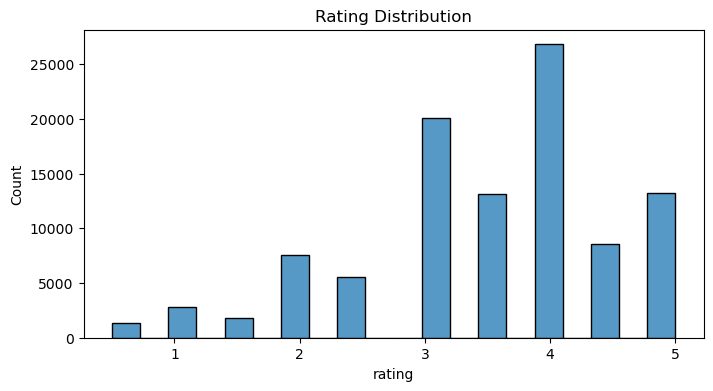

In [13]:
plt.figure(figsize=(8,4))
sns.histplot(ratings['rating'], bins=20, kde=False)
plt.title('Rating Distribution')
plt.show()

### Analyzing Ratings Distribution per User and per Movie  

We use `groupby()` combined with `size()` to count the number of ratings given by each user and received by each movie.  

Then, we apply `describe()` to get summary statistics (count, mean, std, min, max, and percentiles) for these distributions:  

- `ratings_per_user` → Summary of how many ratings each user has made.  
- `ratings_per_movie` → Summary of how many ratings each movie has received.  

This provides insights into user engagement and movie popularity in the dataset.

In [14]:
ratings_per_user = ratings.groupby('userId').size().describe()
ratings_per_movie = ratings.groupby('movieId').size().describe()
print('\nRatings per user (summary):')
print(ratings_per_user)
print('\nRatings per movie (summary):')
print(ratings_per_movie)


Ratings per user (summary):
count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
dtype: float64

Ratings per movie (summary):
count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
dtype: float64


### Extracting Year, Cleaning Titles, and Parsing Genres  

We preprocess the `movies` DataFrame by:  

- Extracting the release year from the movie `title` using a regex that searches for a 4-digit year within parentheses.  
- Creating a new `year` column with the extracted year as an integer (or `None` if not found).  
- Removing the year from the `title` to create a `clean_title` column for clearer display.  
- Splitting the `genres` string into a list of genres in a new column `genres_list` for easier feature extraction in our recommender system.

In [15]:
import re

def extract_year(title):
    m = re.search(r"\((\d{4})\)", title)
    return int(m.group(1)) if m else None

movies['year'] = movies['title'].apply(extract_year)
movies['clean_title'] = movies['title'].str.replace(r"\s*\(\d{4}\)", '', regex=True)
movies['genres_list'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])

### Previewing Updated Movies DataFrame  

Using the `head()` method, we display the first 5 rows of the updated `movies` DataFrame to verify the new columns:  

- `year` extracted from the original title.  
- `clean_title` with the year removed for clarity.  
- `genres_list` containing genres as a list instead of a string.  

This helps confirm our preprocessing steps were applied correctly.

In [16]:
movies.head()

,movieId,title,genres,year,clean_title,genres_list
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0,Jumanji,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0,Grumpier Old Men,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0,Waiting to Exhale,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,1995.0,Father of the Bride Part II,[Comedy]


### Aggregating Tags and Creating Content Feature  

- We preprocess the `tags` column by converting all tags to lowercase and replacing spaces with underscores for uniformity.  
- Using groupby on `movieId`, we aggregate all tags for a movie into a single space-separated string `tags_agg`.  
- We merge the aggregated tags back into the `movies` DataFrame to enrich movie metadata. Missing tags are filled with empty strings.  
- Finally, we create a new `content` column by combining `clean_title`, genres (with pipe replaced by space), and aggregated tags.  
This combined content will be used as input features for content-based movie recommendation.

In [17]:
tags['tag'] = tags['tag'].astype(str).str.lower().str.replace(' ', '_')

movie_tags = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
movie_tags.columns = ['movieId', 'tags_agg']

movies = movies.merge(movie_tags, on='movieId', how='left')
movies['tags_agg'] = movies['tags_agg'].fillna('')

# Creating a content column (title + genres + tags)
movies['content'] = movies['clean_title'] + ' ' + movies['genres'].str.replace('|', ' ') + ' ' + movies['tags_agg']

### Previewing Final Movie Metadata  

We use `head()` to view the first 5 rows of the `movies` DataFrame showing key columns:  

- `movieId`, `title`, `year` for identification and timeline.  
- `genres` and `tags_agg` for categorical information and user tags.  
- `content` column combining title, genres, and tags for content-based analysis.  

This helps confirm all features are correctly assembled and ready for modeling.

In [18]:
movies[['movieId','title','year','genres','tags_agg','content']].head()

,movieId,title,year,genres,tags_agg,content
0,1,Toy Story (1995),1995.0,Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,Toy Story Adventure Animation Children Comedy ...
1,2,Jumanji (1995),1995.0,Adventure|Children|Fantasy,fantasy magic_board_game robin_williams game,Jumanji Adventure Children Fantasy fantasy mag...
2,3,Grumpier Old Men (1995),1995.0,Comedy|Romance,moldy old,Grumpier Old Men Comedy Romance moldy old
3,4,Waiting to Exhale (1995),1995.0,Comedy|Drama|Romance,,Waiting to Exhale Comedy Drama Romance
4,5,Father of the Bride Part II (1995),1995.0,Comedy,pregnancy remake,Father of the Bride Part II Comedy pregnancy r...


### Creating TF-IDF Matrix for Movie Content  

We use `TfidfVectorizer` from scikit-learn to convert the combined movie `content` (title, genres, tags) into a numerical matrix representation.  

- `stop_words='english'` removes common English words that don't add meaning.  
- `max_features=5000` limits the vocabulary size for efficiency.  
- The `fit_transform` method learns the vocabulary and calculates the TF-IDF scores for each movie’s content.  

This matrix will be used to calculate similarities between movies for content-based recommendations.

In [19]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
content_matrix = tfidf.fit_transform(movies['content'])

### Computing Cosine Similarity Matrix  

We calculate the cosine similarity between movies based on their TF-IDF content vectors using `linear_kernel`.  

- `linear_kernel(content_matrix, content_matrix)` computes the dot product between all pairs of movie vectors.  
- Since TF-IDF vectors are L2-normalized, this linear kernel is equivalent to cosine similarity.  
- The resulting matrix (`cos_sim`) represents pairwise similarity scores between movies, crucial for making content-based recommendations.

In [20]:
cos_sim = linear_kernel(content_matrix, content_matrix)

### Creating Series for Movie Title Indexing  

We create a Pandas Series named `indices` that maps movie titles to their corresponding row indices in the `movies` DataFrame.  

- This allows quick lookup of a movie’s index by its title, which is useful for recommendation queries.  
- The `drop_duplicates()` method ensures that if there are duplicate titles, only the first occurrence is kept, preventing indexing conflicts.

In [21]:
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

### Content-Based Recommendation Function  

This function, `content_recommendations`, takes a movie title as input and returns the top N most similar movies based on content similarity:  

- It looks up the movie's index using the `indices` Series.  
- Retrieves similarity scores from the precomputed `cos_sim` matrix for that movie.  
- Sorts movies by similarity score in descending order, excluding the input movie itself.  
- Returns a DataFrame of the most similar movies with their `movieId`, `title`, and `genres`.  

This function enables quick and effective content-based movie recommendations.

In [22]:
def content_recommendations(title, topn=10):
    if title not in indices:
        print('Title not found in dataset. Try an exact title from movies.title')
        return []
    idx = indices[title]
    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:topn+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices][['movieId','title','genres']]

### Testing Content-Based Recommendations  

We test the recommendation function by requesting similar movies to *Toy Story (1995)*.  

This demonstrates the model’s ability to find movies with similar titles, genres, and user tags based on content similarity.

In [23]:
print('Recommendations for Toy Story (1995):')
content_recommendations('Toy Story (1995)', topn=10)

Recommendations for Toy Story (1995):


,movieId,title,genres
2355,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
1757,2355,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy
7355,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
3595,4929,"Toy, The (1982)",Comedy
7039,68954,Up (2009),Adventure|Animation|Children|Drama
3733,5178,Fun (1994),Crime|Drama
1706,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
9430,166461,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy
2539,3400,We're Back! A Dinosaur's Story (1993),Adventure|Animation|Children|Fantasy
6205,45431,Over the Hedge (2006),Adventure|Animation|Children|Comedy


### Loading Ratings Data into Surprise Dataset  

- We define a `Reader` object specifying the rating scale using the minimum and maximum ratings from our `ratings` DataFrame.  
- Using `Dataset.load_from_df`, we load the user-movie-rating triplets into a Surprise dataset format.  

This prepares the data for building collaborative filtering models with the Surprise library.

In [24]:
reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))

data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)

### Splitting Dataset into Training and Testing Sets  

We split the Surprise `data` into training and testing sets using `surprise_train_test_split`:  

- `test_size=0.2` means 20% of ratings are reserved for testing, 80% for training.  
- `random_state=42` ensures reproducibility of the random split.  

This separation allows unbiased evaluation of collaborative filtering models on unseen data.

In [25]:
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

### Training the SVD Collaborative Filtering Model  

We instantiate the `SVD` algorithm from Surprise with:  
- `n_factors=50` latent factors to represent users and items.  
- `n_epochs=20` iterations for stochastic gradient descent optimization.  
- `random_state=42` for reproducibility.  

Then, we fit the model on the training set using `svd.fit(trainset)`.  
This trains the matrix factorization model to learn underlying patterns in user ratings for personalized recommendations.

In [26]:
svd = SVD(n_factors=50, n_epochs=20, random_state=42)
svd.fit(trainset)

### Evaluating the SVD Model Performance  

- We use the trained `svd` model to predict ratings on the test set with `svd.test(testset)`.  
- Using Surprise's `accuracy` module, we calculate:  
  - RMSE (Root Mean Squared Error) to measure the average magnitude of prediction errors, penalizing larger errors more.  
  - MAE (Mean Absolute Error) to measure the average absolute difference between predicted and true ratings.  
- Printing these metrics provides an indication of how well the model predicts user ratings on unseen data.

In [27]:
predictions = svd.test(testset)
rmse_svd = accuracy.rmse(predictions)
mae_svd = accuracy.mae(predictions)
print(f'SVD RMSE: {rmse_svd}, MAE: {mae_svd}')

RMSE: 0.8775
MAE:  0.6742
SVD RMSE: 0.8774680781839199, MAE: 0.6741748366526163


### SVD Model Performance Results  

- Our SVD collaborative filtering model achieves an RMSE of approximately **0.8775** and an MAE of **0.6742** on the test set.  
- These metrics indicate relatively accurate predictions with reasonable error margins for user ratings.

### Training and Evaluating KNN Item-Based Model  

- We configure a K-Nearest Neighbors (KNN) model with cosine similarity, set for item-based collaborative filtering (`user_based=False`).  
- The model is trained on the training set and evaluated on the test set.  
- The KNN item-based model achieves an RMSE of about **0.98** and MAE of **0.76**, slightly less accurate than the SVD model.  

This comparison shows the advantage of matrix factorization (SVD) over simpler neighborhood-based methods in this context.

In [28]:
sim_options = {'name': 'cosine', 'user_based': False}
knn_item = KNNBasic(sim_options=sim_options)
knn_item.fit(trainset)
predictions_knn = knn_item.test(testset)
rmse_knn = accuracy.rmse(predictions_knn)
mae_knn = accuracy.mae(predictions_knn)
print(f'KNN Item RMSE: {rmse_knn}, MAE: {mae_knn}')

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9800
MAE:  0.7615
KNN Item RMSE: 0.97995665962038, MAE: 0.7614697475628528


### Extracting Top-N Recommendations for Each User  

This utility function `get_top_n` processes a list of predictions and returns the top N recommended items for each user:  

- It groups predictions by user ID into a dictionary with user IDs as keys.  
- For each user, it sorts the predicted item ratings in descending order.  
- Keeps only the top N highest scored items for each user.  

This method is useful for generating personalized recommendation lists from collaborative filtering model predictions.

In [29]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    # Map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Sort the predictions for each user and retrieve the n highest
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

### Training SVD Model on Full Dataset  

- We build a training set using all available data with `build_full_trainset()`.  
- Instantiate a new `SVD` model with the same hyperparameters as before.  
- Train the SVD model on the full dataset to leverage all user ratings for the best possible model.  

This full-data model can be used for final predictions and recommendations.

In [30]:
trainset_full = data.build_full_trainset()
svd_full = SVD(n_factors=50, n_epochs=20, random_state=42)
svd_full.fit(trainset_full)

### Generating Top-10 Recommendations for All Users  

- We create an `anti_testset` which consists of all user-item pairs NOT seen in the training data (i.e., movies users haven't rated).  
- Using the fully trained `svd_full` model, we predict ratings for these unseen user-item pairs.  
- We then apply the `get_top_n` function to extract the top 10 highest predicted rating recommendations for each user.  

This process yields personalized top-10 movie recommendations for every user based on the model’s learned preferences.

In [31]:
anti_testset = trainset_full.build_anti_testset()
predictions_all = svd_full.test(anti_testset)

top_n = get_top_n(predictions_all, n=10)

### Viewing Top-10 Recommendations for a Specific User  

- We display the top 10 recommended movies for user with ID 1 from the `top_n` dictionary.  
- Each entry shows the movie ID and the model’s estimated rating score.  

This allows inspection of personalized recommendations generated by the collaborative filtering model.

In [32]:
print('Top-10 recommendations (movieId, estimated rating) for user 1:')
print(top_n[1])

Top-10 recommendations (movieId, estimated rating) for user 1:
[(318, 5.0), (48516, 5.0), (58559, 5.0), (899, 5.0), (904, 5.0), (912, 5.0), (750, 5.0), (4993, 5.0), (7153, 5.0), (858, 5.0)]


### Displaying Detailed Recommendations for a User  

The `show_user_recommendations` function:  

- Takes a user ID and the dictionary of top-N recommendations.  
- Retrieves the recommended movie IDs and estimated ratings for the user.  
- Merges these with the `movies` DataFrame to include movie titles and genres for better readability.  
- Returns a DataFrame showing personalized movie recommendations with relevant details.  

This function facilitates easy review of recommendations in a user-friendly format.

In [33]:
def show_user_recommendations(user_id, top_n_recs):
    recs = top_n_recs.get(user_id, [])
    recs_df = pd.DataFrame(recs, columns=['movieId','est'])
    recs_df = recs_df.merge(movies[['movieId','title','genres']], on='movieId')
    return recs_df

show_user_recommendations(1, top_n)

,movieId,est,title,genres
0,318,5.0,"Shawshank Redemption, The (1994)",Crime|Drama
1,48516,5.0,"Departed, The (2006)",Crime|Drama|Thriller
2,58559,5.0,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
3,899,5.0,Singin' in the Rain (1952),Comedy|Musical|Romance
4,904,5.0,Rear Window (1954),Mystery|Thriller
5,912,5.0,Casablanca (1942),Drama|Romance
6,750,5.0,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
7,4993,5.0,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
8,7153,5.0,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
9,858,5.0,"Godfather, The (1972)",Crime|Drama


### Precision and Recall at K for Recommendation Evaluation  

- The `precision_recall_at_k` function evaluates the quality of recommendations by computing precision and recall metrics at a cutoff rank \(k\).  
- For each user, it sorts predicted ratings and calculates:  
  - **Precision@k**: Proportion of recommended items in the top \(k\) that are truly relevant (above a rating threshold).  
  - **Recall@k**: Proportion of all relevant items that appear in the top \(k\) recommendations.  
- The function returns the average precision and recall across all users, providing insights into both accuracy and coverage of recommendations within the top ranked items.  

This helps assess how well the recommender balances recommending relevant movies while covering the user's interests.

In [34]:
def precision_recall_at_k(predictions, k=10, threshold=4.0):
    user_est = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est[uid].append((iid, est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        n_rel = sum((true_r >= threshold) for (_,_,true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (_,est,_) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (_,est,true_r) in user_ratings[:k])
       
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    mean_precision = np.mean(list(precisions.values()))
    mean_recall = np.mean(list(recalls.values()))
    return mean_precision, mean_recall

### Evaluating Model with Precision@10 and Recall@10  

- We calculate precision and recall at top 10 recommendations using the `precision_recall_at_k` function.  
- A threshold of 4.0 is used to define which ratings are considered relevant.  
- The resulting metrics provide a balanced measure of recommendation accuracy (precision) and comprehensiveness (recall) at the cutoff point.  

This evaluation helps understand the effectiveness of the recommender in delivering relevant movies within the first 10 suggestions.

In [35]:
prec_k, rec_k = precision_recall_at_k(predictions, k=10, threshold=4.0)
print(f'Precision@10: {prec_k:.4f}, Recall@10: {rec_k:.4f}')

Precision@10: 0.5686, Recall@10: 0.2867


### Displaying User Rating History  

- We filter the `ratings` DataFrame to get the top 10 highest-rated movies by user with ID 1.  
- The result is merged with the `movies` DataFrame to include movie titles for readability.  
- This provides context about the user’s preferences and past interactions relevant to recommendation evaluation. 

In [36]:
user_id = 1
user_history = ratings[ratings['userId'] == user_id].sort_values('rating', ascending=False).head(10)
print('User history (top 10 by rating):')
print(user_history.merge(movies[['movieId','title']], on='movieId'))

User history (top 10 by rating):
   userId  movieId  rating  timestamp  \
0       1     5060     5.0  964984002   
1       1     2872     5.0  964981680   
2       1     1291     5.0  964981909   
3       1     1298     5.0  964984086   
4       1     2948     5.0  964982191   
5       1     2947     5.0  964982176   
6       1     2944     5.0  964981872   
7       1     2899     5.0  964982703   
8       1     2858     5.0  964980868   
9       1     2700     5.0  964980985   

                                         title  
0                 M*A*S*H (a.k.a. MASH) (1970)  
1                             Excalibur (1981)  
2    Indiana Jones and the Last Crusade (1989)  
3                  Pink Floyd: The Wall (1982)  
4                 From Russia with Love (1963)  
5                            Goldfinger (1964)  
6                      Dirty Dozen, The (1967)  
7                    Gulliver's Travels (1939)  
8                       American Beauty (1999)  
9  South Park: Bigger, Lo

### Comparing Content-Based and Collaborative Recommendations for a User  

- We first identify the user's top-rated movie and generate content-based recommendations similar to that movie.  
- We then display the collaborative filtering (SVD) top-10 recommendations personalized for the user.  

This comparison showcases how content-based and collaborative models provide complementary recommendations tailored to the user's preferences.

In [37]:
if not user_history.empty:
    top_movie_title = movies[movies['movieId'] == user_history.iloc[0]['movieId']]['title'].values[0]
    print('\nContent-based recommendations based on user\'s top movie:')
    display(content_recommendations(top_movie_title, topn=10))

print('\nCollaborative recommendations (SVD) for the user:')
display(show_user_recommendations(user_id, top_n))


Content-based recommendations based on user's top movie:


,movieId,title,genres
3673,5060,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War
7344,78142,Baarìa (2009),Comedy|Drama|War
130,157,Canadian Bacon (1995),Comedy|War
4773,7104,1941 (1979),Comedy|War
1279,1696,Bent (1997),Drama|War
1540,2075,Mephisto (1981),Drama|War
1760,2358,Savior (1998),Drama|War
2334,3091,Kagemusha (1980),Drama|War
2501,3342,Birdy (1984),Drama|War
3026,4047,Gettysburg (1993),Drama|War



Collaborative recommendations (SVD) for the user:


,movieId,est,title,genres
0,318,5.0,"Shawshank Redemption, The (1994)",Crime|Drama
1,48516,5.0,"Departed, The (2006)",Crime|Drama|Thriller
2,58559,5.0,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
3,899,5.0,Singin' in the Rain (1952),Comedy|Musical|Romance
4,904,5.0,Rear Window (1954),Mystery|Thriller
5,912,5.0,Casablanca (1942),Drama|Romance
6,750,5.0,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
7,4993,5.0,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
8,7153,5.0,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
9,858,5.0,"Godfather, The (1972)",Crime|Drama


### Hybrid Recommendation System Combining Collaborative and Content-Based Scores  

The `hybrid_recommendations_for_user` function generates recommendations by blending:  

1. Collaborative filtering scores from the fully trained SVD model for movies the user hasn't rated.  
2. Content similarity scores based on the average similarity of candidate movies to the user's top 5 liked movies using the content cosine similarity matrix.  

Key steps:  
- Candidates exclude movies the user has already rated.  
- Content similarity is averaged across favorites to represent general content preference.  
- Scores are normalized via MinMaxScaler for comparability.  
- A weighted sum of collaborative and content scores is computed with parameter α controlling the blend.  
- Top N movies with highest hybrid scores are returned with titles and genres.  

This approach leverages strengths of both recommendation types for improved personalization.

In [38]:
from sklearn.preprocessing import MinMaxScaler

def hybrid_recommendations_for_user(user_id, topn=10, alpha=0.5):
    # 1) Collaborative scores from SVD
    user_rated = set(ratings[ratings['userId']==user_id]['movieId'].unique())
    all_movie_ids = set(movies['movieId'].unique())
    candidates = list(all_movie_ids - user_rated)

    collab_scores = []
    for mid in candidates:
        est = svd_full.predict(user_id, mid).est
        collab_scores.append((mid, est))
    collab_df = pd.DataFrame(collab_scores, columns=['movieId','collab_est'])

    # 2) Content score: average similarity of candidate to user's top N liked movies
    user_top_movies = ratings[ratings['userId']==user_id].sort_values('rating', ascending=False).head(5)['movieId'].values
    # If user has no history, fall back to popularity
    if len(user_top_movies) == 0:
        print('No history for user - returning popular items')
        popular = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False).head(topn).index
        return movies[movies['movieId'].isin(popular)][['movieId','title','genres']]

    # we compute content similarity vector for each candidate relative to user's top movies
    # We'll compute average cosine similarity between candidate and each favorite movie
    fav_indices = [movies.index[movies['movieId']==m].tolist()[0] for m in user_top_movies if not movies.index[movies['movieId']==m].empty]

    content_scores = []
    for mid in candidates:
        try:
            cand_idx = movies.index[movies['movieId']==mid].tolist()[0]
        except IndexError:
            continue
        sims = [cos_sim[cand_idx][fav_idx] for fav_idx in fav_indices]
        avg_sim = np.mean(sims) if len(sims)>0 else 0
        content_scores.append((mid, avg_sim))
    content_df = pd.DataFrame(content_scores, columns=['movieId','content_sim'])

    # Merge and normalize
    merged = collab_df.merge(content_df, on='movieId', how='inner')
    scaler = MinMaxScaler()
    merged[['collab_norm','content_norm']] = scaler.fit_transform(merged[['collab_est','content_sim']])
    # Weighted score
    merged['hybrid_score'] = alpha * merged['collab_norm'] + (1-alpha) * merged['content_norm']
    merged = merged.sort_values('hybrid_score', ascending=False).head(topn)
    result = merged.merge(movies[['movieId','title','genres']], on='movieId')
    return result[['movieId','title','genres','hybrid_score']]

### Generating Hybrid Recommendations for User 1  

- Calling the `hybrid_recommendations_for_user` function with user ID 1.  
- Using an alpha value of 0.6 to give more weight to collaborative filtering while still incorporating content similarity.  
- Returns the top 10 personalized movie recommendations blending both collaborative and content-based approaches, including movie titles, genres, and computed hybrid scores.  

This demonstrates the use of a hybrid system to balance collaborative predictions and content similarity for enhanced recommendations.

In [39]:
hybrid_recommendations_for_user(1, topn=10, alpha=0.6)

,movieId,title,genres,hybrid_score
0,69481,"Hurt Locker, The (2008)",Action|Drama|Thriller|War,0.834856
1,4047,Gettysburg (1993),Drama|War,0.803926
2,7143,"Last Samurai, The (2003)",Action|Adventure|Drama|War,0.800282
3,1204,Lawrence of Arabia (1962),Adventure|Drama|War,0.796646
4,7840,Gunga Din (1939),Adventure|Comedy|War,0.793649
5,5965,"Duellists, The (1977)",Action|War,0.775410
6,65216,Defiance (2008),Drama|Thriller|War,0.773181
7,3091,Kagemusha (1980),Drama|War,0.762073
8,53,Lamerica (1994),Adventure|Drama,0.761819
9,3342,Birdy (1984),Drama|War,0.755370


### Saving Models and Data for Future Use  

- The TF-IDF vectorizer (`tfidf`) is serialized and saved to `tfidf_vectorizer.pkl` for later reuse in processing new movie content.  
- The fully trained SVD collaborative filtering model (`svd_full`) is saved to `svd_model.pkl`.  
- The preprocessed `movies` DataFrame, containing metadata and content features, is saved as `movies_df.pkl`.  

Saving these artifacts facilitates efficient deployment or future model updates without retraining from scratch.

In [40]:
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

with open('svd_model.pkl', 'wb') as f:
    pickle.dump(svd_full, f)

movies.to_pickle('movies_df.pkl')
print('Saved tfidf_vectorizer.pkl, svd_model.pkl, movies_df.pkl')

Saved tfidf_vectorizer.pkl, svd_model.pkl, movies_df.pkl


### Streamlit App for Interactive Movie Recommendations  

I've added app.py in the same directory as of this notebook, which sets up a Streamlit web app for demoing the movie recommender system with three modes: Collaborative (SVD), Content-based, and Hybrid, which we've discussed above.

**Key features:**  
- **Loading artifacts:** The TF-IDF vectorizer, trained SVD model, movies DataFrame, and content similarity matrix are loaded using a cached function to avoid repeated loading and computation.  
- **User input:** The app takes a user ID (integer) and lets users select the recommendation mode.  
- **Content-based recommendations:** Based on cosine similarity of combined movie content (title, genres, tags), it suggests movies similar to a user-chosen title.  
- **Collaborative filtering:** Uses the SVD model to predict and rank movies for a user based on latent factors derived from user-item rating interactions.  
- **Hybrid recommendations:** Combines collaborative and content scores weighted by a user-controllable alpha slider, blending personalization with content similarity.  
- **Interactivity:** Users can easily switch modes and input values, with recommendations displayed in tabular form in real-time.  

This serves as a user-friendly interface for exploring different recommendation approaches built in this notebook.